In [1]:
import os

import numpy as np
import pandas as pd

In [2]:
import scanpy.api as sc
import scanorama

In [3]:
os.chdir("./merged_zebrafish_seas/")

In [4]:
species1_dge = sc.AnnData(pd.read_csv("./SeaSquirts/seasquirts_cell100_vargenes.csv").fillna(0).T )
species2_dge = sc.AnnData(pd.read_csv("./zebrafish/zebrafish_cell100_vargenes.csv").fillna(0).T )

In [5]:
print(species1_dge.shape, species2_dge.shape)

(5434, 1368) (26053, 1368)


In [6]:
intergrated, corrected = scanorama.correct_scanpy([species1_dge, species2_dge], return_dimred=True)
corrected_species1_dge, corrected_species2_dge = corrected
corrected_merged_dge = corrected_species1_dge.concatenate(corrected_species2_dge, join='outer')

Found 1368 genes among all datasets
[[0.         0.29499448]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/ggj/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/home/ggj/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):


In [7]:
corrected_merged_dge

AnnData object with n_obs × n_vars = 31487 × 1368 
    obs: 'batch'

In [8]:
species1_anno = pd.read_table("./SeaSquirts/SeaSquirts.SRS.phe1", header=0)
species2_anno = pd.read_table("./zebrafish/Zebrafish.SRS.phe", header=0)

In [9]:
merged_anno = species1_anno.append(species2_anno, sort=False)
print(merged_anno.shape)
merged_anno.iloc[1:5,]

(31487, 3)


,CellID,Tissue,Celltype
1,Larva2_GCGCAACGTGCAGGTA-1,Ciona,Ciona1
2,Larva2_CAACTAGCACCTATCC-1,Ciona,Ciona1
3,Larva2_CAAGATCAGCGATATA-1,Ciona,Ciona1
4,Larva1_CCTACACGTCCCTTGT-1,Ciona,Ciona1


In [10]:
celltype_anno = pd.read_table("./var_genes/438celltype-NEW-20190728.annotation", sep='\t')
celltype_anno['Cluster'] = celltype_anno['Cluster'].apply(lambda x: x.split('.')[0])
celltype_anno['Sub_Cluster'] = celltype_anno['Sub_Cluster'].apply(lambda x: x.split('.')[0])
print(celltype_anno.shape)
celltype_anno.head()

(437, 4)


,Celltype,Species,Cluster,Sub_Cluster
0,Rectum.c,Celegans,Rectum,Epithelial
1,Germline.c,Celegans,Proliferating,Proliferating
2,Sex myoblasts.c,Celegans,Proliferating,Proliferating
3,Somatic gonad precursors.c,Celegans,Proliferating,Proliferating
4,Vulval precursors.c,Celegans,Proliferating,Proliferating


In [11]:
merged_celltype_anno = pd.merge(merged_anno, celltype_anno, how='left', on=['Celltype'])
print(merged_celltype_anno.shape)
merged_celltype_anno.head()

(31487, 6)


,CellID,Tissue,Celltype,Species,Cluster,Sub_Cluster
0,Larva1_ACTATCTTCTCAAACG-1,Ciona,Ciona1,SeaSquirts,Mesenchyme,Mesenchyme
1,Larva2_GCGCAACGTGCAGGTA-1,Ciona,Ciona1,SeaSquirts,Mesenchyme,Mesenchyme
2,Larva2_CAACTAGCACCTATCC-1,Ciona,Ciona1,SeaSquirts,Mesenchyme,Mesenchyme
3,Larva2_CAAGATCAGCGATATA-1,Ciona,Ciona1,SeaSquirts,Mesenchyme,Mesenchyme
4,Larva1_CCTACACGTCCCTTGT-1,Ciona,Ciona1,SeaSquirts,Mesenchyme,Mesenchyme


In [12]:
corrected_merged_dge.obs['cellID']=merged_celltype_anno['CellID'].values
corrected_merged_dge.obs['Celltype']=merged_celltype_anno['Celltype'].values
corrected_merged_dge.obs['Cluster']=merged_celltype_anno['Cluster'].values
corrected_merged_dge.obs['Sub_Cluster']=merged_celltype_anno['Sub_Cluster'].values
corrected_merged_dge.obs['Species']=merged_celltype_anno['Species'].values

In [23]:
corrected_merged_dge.obs.to_csv("./merged/corrected_merged_dgeobs.csv")

In [24]:
corrected_merged_dge.write('./merged/corrected_merged_mouse_human_dge.h5ad')

... storing 'Celltype' as categorical
... storing 'Cluster' as categorical
... storing 'Sub_Cluster' as categorical
... storing 'Species' as categorical


In [13]:
##scanpy_visualization
sc.pp.normalize_per_cell(corrected_merged_dge, counts_per_cell_after=1e6)
sc.pp.scale(corrected_merged_dge)

In [14]:
corrected_merged_dge

AnnData object with n_obs × n_vars = 31482 × 1368 
    obs: 'batch', 'cellID', 'Celltype', 'Cluster', 'Sub_Cluster', 'Species', 'n_counts'

In [15]:
sc.tl.pca(corrected_merged_dge, n_comps=100)

saving figure to file ./figures/pca_variance_ratio_pca.png


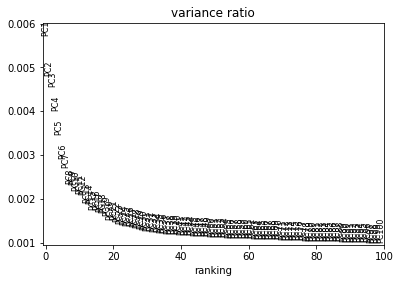

In [16]:
sc.pl.pca_variance_ratio(corrected_merged_dge, n_pcs=100, log=False, save="_pca.png")

In [17]:
sc.pp.neighbors(corrected_merged_dge, n_neighbors=10, n_pcs=40)

In [18]:
sc.tl.tsne(corrected_merged_dge, n_pcs=40, learning_rate=1000, perplexity=30, early_exaggeration=20, use_fast_tsne=True, n_jobs=25)

... storing 'Celltype' as categorical
... storing 'Cluster' as categorical
... storing 'Sub_Cluster' as categorical
... storing 'Species' as categorical


saving figure to file ./figures/tsne_batch_merged.pdf


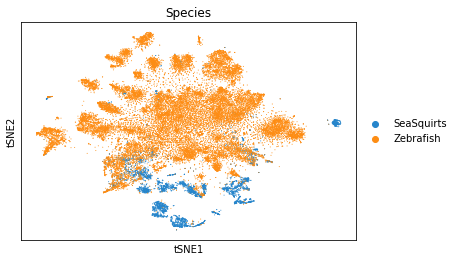

In [19]:
col1=["#2685cb", "#fd8d14"]
sc.pl.tsne(corrected_merged_dge, color='Species', palette=col1, save='_batch_merged.pdf')

saving figure to file ./figures/tsne_merged_celltype.pdf


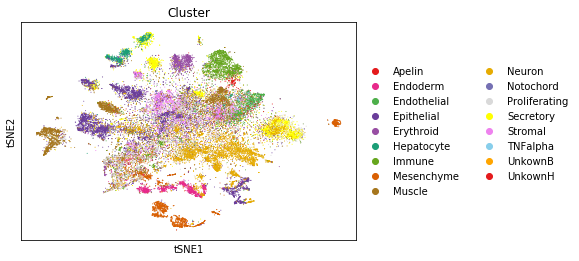

In [20]:
col2 = ["#E41A1C","#E7298A","#4DAF4A","#6A3D9A","#984EA3","#1B9E77","#66A61E","#D95F02","#A6761D","#E6AB02","#7570B3", '#D9D9D9','#FFFF00', '#EE82EE', '#87CEEB', '#FFA500']
#col2 = ['#D9D9D9','#D9D9D9','#D9D9D9','#D9D9D9','#D9D9D9','#D9D9D9','#D9D9D9','#D9D9D9','#D9D9D9','#D9D9D9', '#D9D9D9',"#E41A1C"]
sc.pl.tsne(corrected_merged_dge, color='Cluster', palette=col2, save='_merged_celltype.pdf')

saving figure to file ./figures/tsne_merged_SubCelltype.pdf


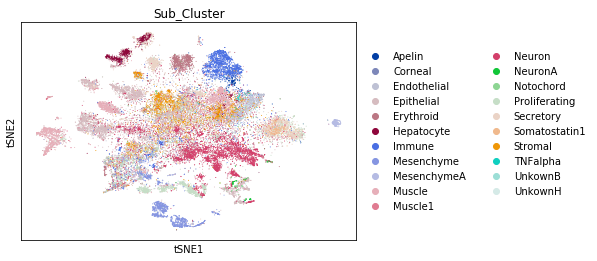

In [21]:
sc.pl.tsne(corrected_merged_dge, color='Sub_Cluster', save='_merged_SubCelltype.pdf')

saving figure to file ./figures/tsne_Mesenchyme_Celltype.pdf


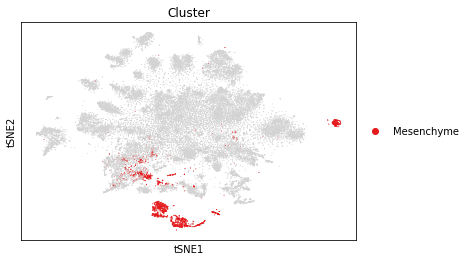

saving figure to file ./figures/tsne_Proliferating_Celltype.pdf


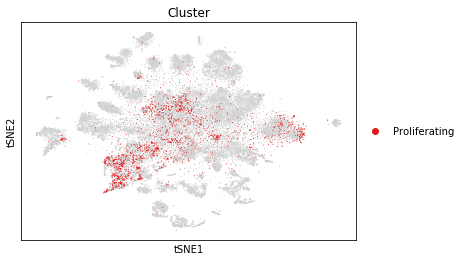

saving figure to file ./figures/tsne_Neuron_Celltype.pdf


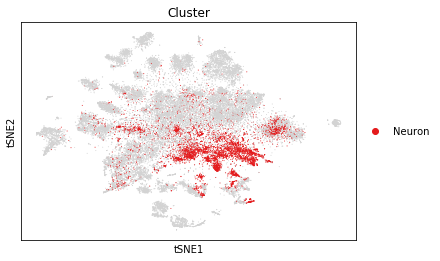

saving figure to file ./figures/tsne_Muscle_Celltype.pdf


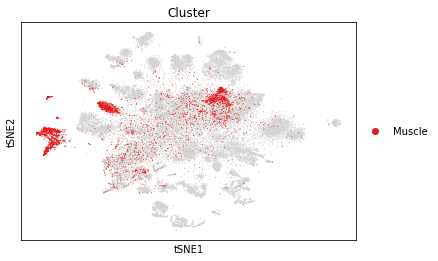

saving figure to file ./figures/tsne_Epithelial_Celltype.pdf


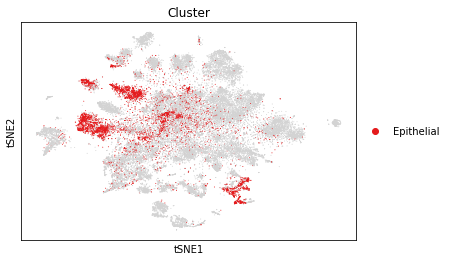

saving figure to file ./figures/tsne_Notochord_Celltype.pdf


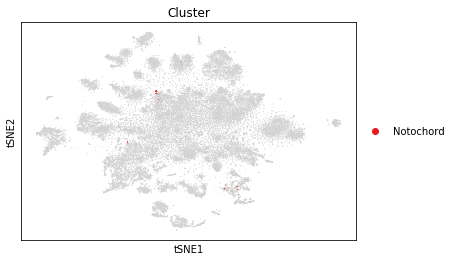

saving figure to file ./figures/tsne_Endoderm_Celltype.pdf


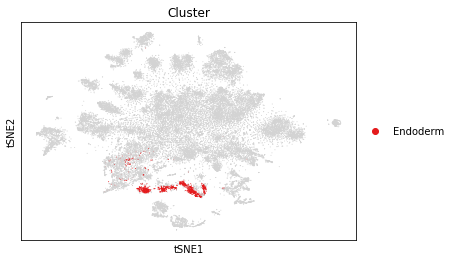

saving figure to file ./figures/tsne_Apelin_Celltype.pdf


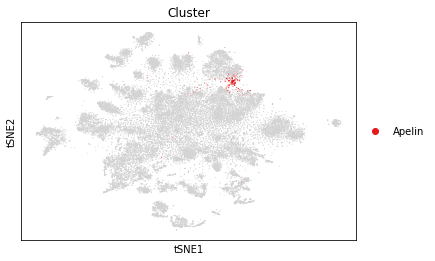

saving figure to file ./figures/tsne_Immune_Celltype.pdf


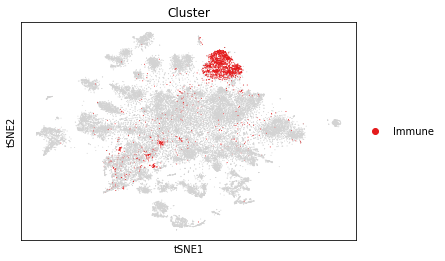

saving figure to file ./figures/tsne_Endothelial_Celltype.pdf


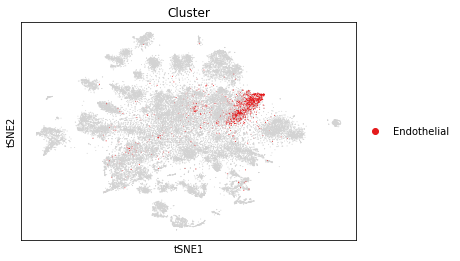

saving figure to file ./figures/tsne_Erythroid_Celltype.pdf


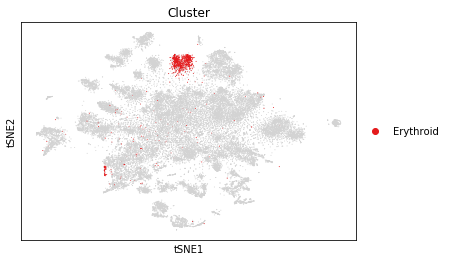

saving figure to file ./figures/tsne_Stromal_Celltype.pdf


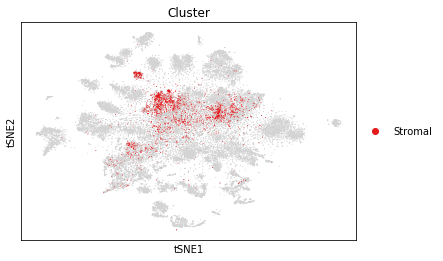

saving figure to file ./figures/tsne_Hepatocyte_Celltype.pdf


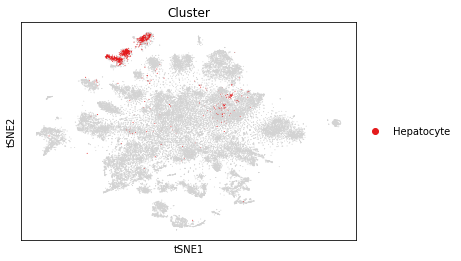

saving figure to file ./figures/tsne_Secretory_Celltype.pdf


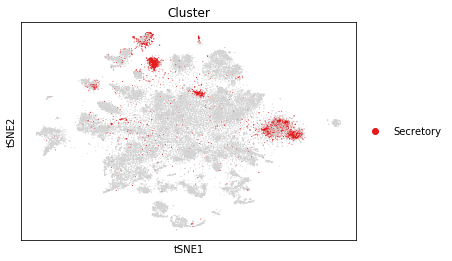

saving figure to file ./figures/tsne_TNFalpha_Celltype.pdf


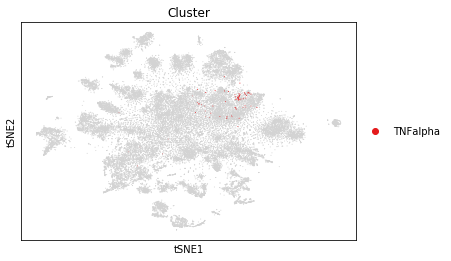

saving figure to file ./figures/tsne_UnkownB_Celltype.pdf


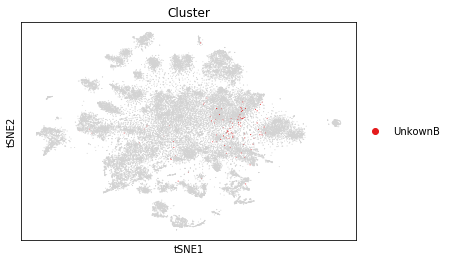

saving figure to file ./figures/tsne_UnkownH_Celltype.pdf


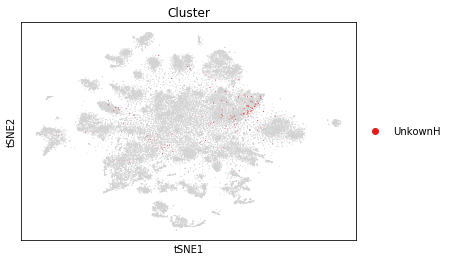

saving figure to file ./figures/tsne_Mesenchyme_SubCelltype.pdf


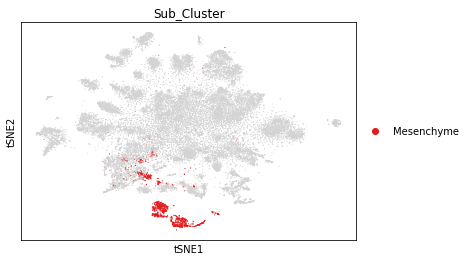

saving figure to file ./figures/tsne_Proliferating_SubCelltype.pdf


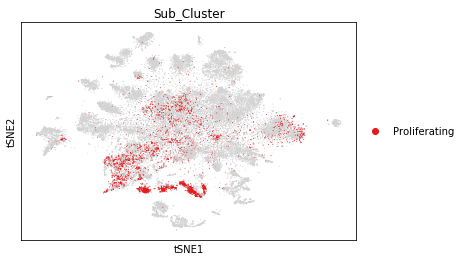

saving figure to file ./figures/tsne_Neuron_SubCelltype.pdf


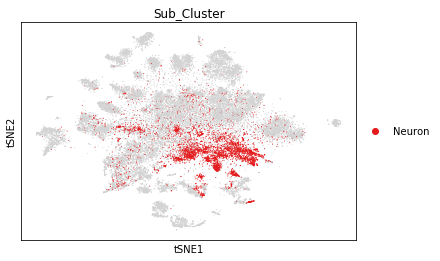

saving figure to file ./figures/tsne_MesenchymeA_SubCelltype.pdf


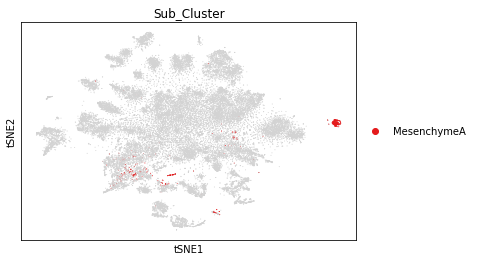

saving figure to file ./figures/tsne_Muscle1_SubCelltype.pdf


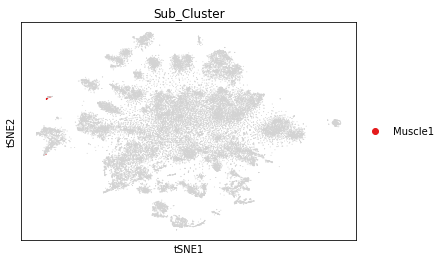

saving figure to file ./figures/tsne_Epithelial_SubCelltype.pdf


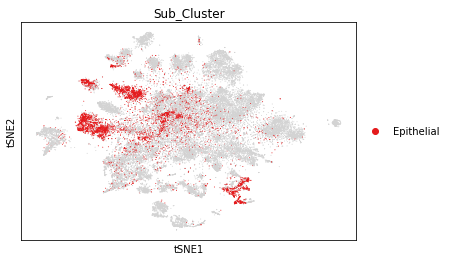

saving figure to file ./figures/tsne_NeuronA_SubCelltype.pdf


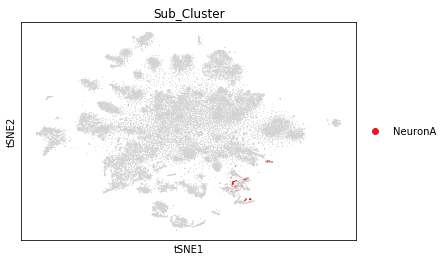

saving figure to file ./figures/tsne_Muscle_SubCelltype.pdf


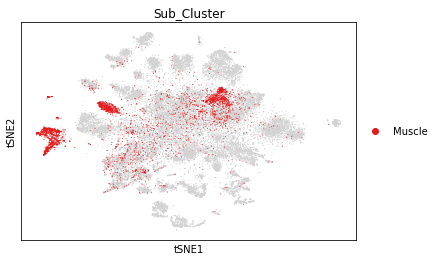

saving figure to file ./figures/tsne_Notochord_SubCelltype.pdf


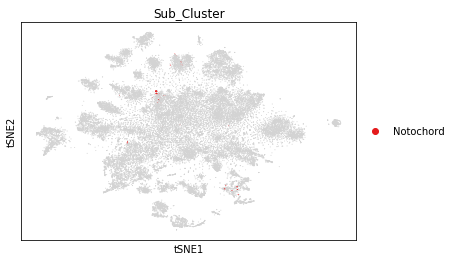

saving figure to file ./figures/tsne_Apelin_SubCelltype.pdf


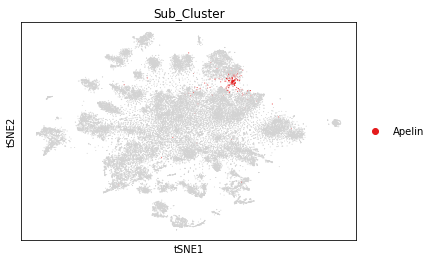

saving figure to file ./figures/tsne_Immune_SubCelltype.pdf


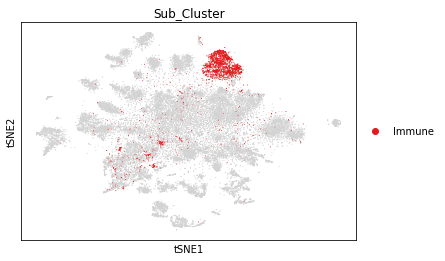

saving figure to file ./figures/tsne_Endothelial_SubCelltype.pdf


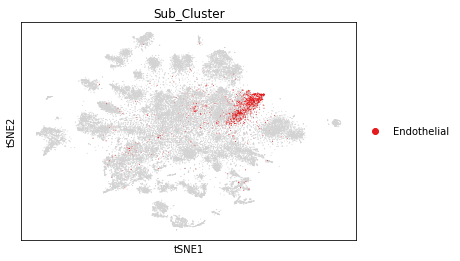

saving figure to file ./figures/tsne_Erythroid_SubCelltype.pdf


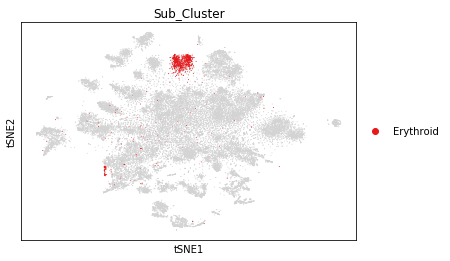

saving figure to file ./figures/tsne_Stromal_SubCelltype.pdf


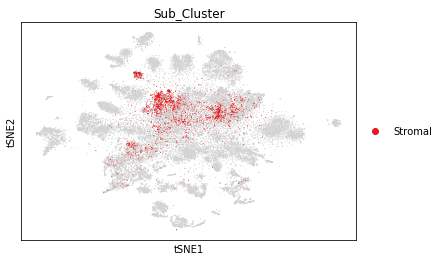

saving figure to file ./figures/tsne_Hepatocyte_SubCelltype.pdf


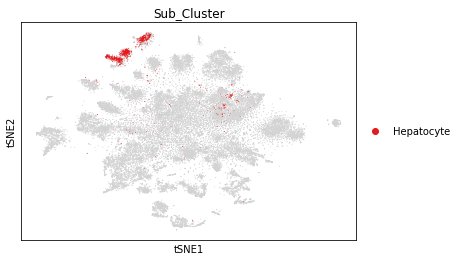

saving figure to file ./figures/tsne_Secretory_SubCelltype.pdf


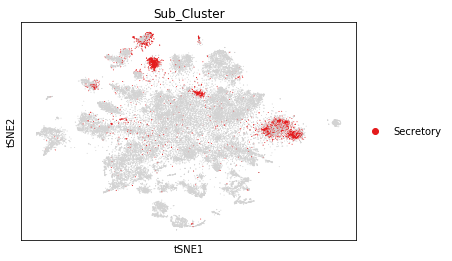

saving figure to file ./figures/tsne_Somatostatin1_SubCelltype.pdf


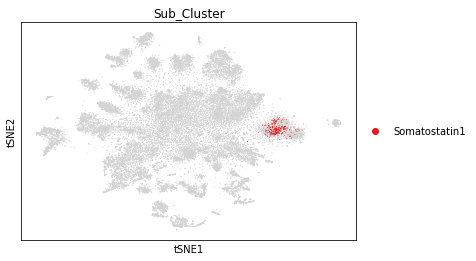

saving figure to file ./figures/tsne_TNFalpha_SubCelltype.pdf


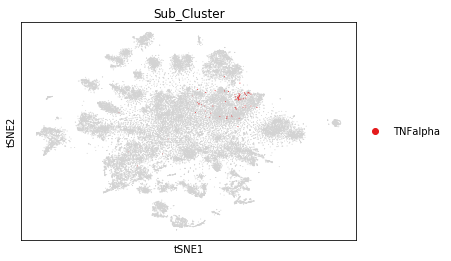

saving figure to file ./figures/tsne_UnkownB_SubCelltype.pdf


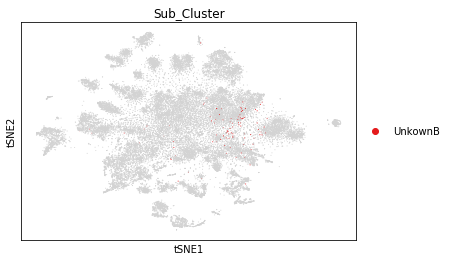

saving figure to file ./figures/tsne_UnkownH_SubCelltype.pdf


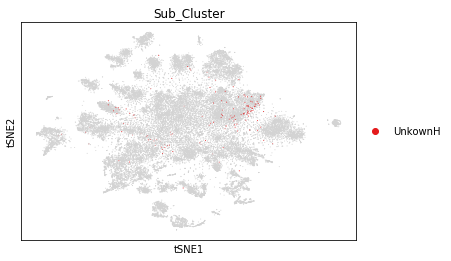

saving figure to file ./figures/tsne_Corneal_SubCelltype.pdf


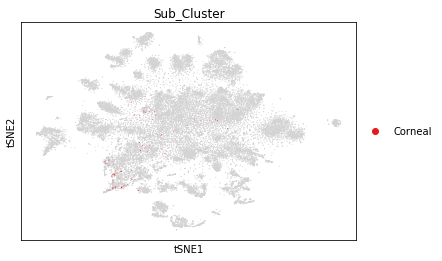

In [22]:
#sc.pl.tsne(corrected_merged_dge, color='Sub_Cluster', save='_merged_SubCelltype.pdf')
#sc.pl.tsne(corrected_merged_dge, color='Cluster', groups=['Secretory', 'Endothelial'], palette=['#E41A1C',"#66A61E"], save= '_Secretory_Endothelial' + '_SubCelltype.pdf')
for subcluster in corrected_merged_dge.obs['Cluster'].drop_duplicates():
   sc.pl.tsne(corrected_merged_dge, color='Cluster', groups=[subcluster], palette=['#E41A1C'], save= '_' + subcluster + '_Celltype.pdf')
for subcluster in corrected_merged_dge.obs['Sub_Cluster'].drop_duplicates():
   sc.pl.tsne(corrected_merged_dge, color='Sub_Cluster', groups=[subcluster], palette=['#E41A1C'], save= '_' + subcluster + '_SubCelltype.pdf')

In [61]:
sc.tl.umap(corrected_merged_dge)

In [62]:
sc.pl.umap(corrected_merged_dge, color='Cluster', palette=col2, save='_umap_merged_celltype.pdf')

saving figure to file ./figures/umap_umap_merged_celltype.pdf


/home/ggj/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/home/ggj/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


In [23]:
sc.tl.louvain(corrected_merged_dge)
sc.tl.rank_genes_groups(corrected_merged_dge, 'louvain', method='wilcoxon')

In [24]:
result = corrected_merged_dge.uns['rank_genes_groups']
groups = result['names'].dtype.names
marker_genes = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']})

In [25]:
marker_genes.to_csv("./merged/marker_genes_ZSS4.csv")

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 31482 × 1368 
    obs: 'batch', 'cellID', 'Celltype', 'Cluster', 'Sub_Cluster', 'Species', 'n_counts', 'louvain'
    uns: 'pca', 'neighbors', 'Species_colors', 'Cluster_colors', 'Sub_Cluster_colors', 'louvain', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'>
saving figure to file ./figures/tsne_louvain_merged.pdf


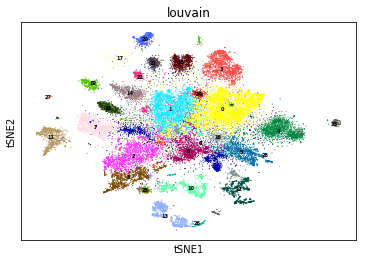

In [26]:
print(corrected_merged_dge.obs_keys)
sc.pl.tsne(corrected_merged_dge, color='louvain', save='_louvain_merged.pdf', legend_loc='on data', legend_fontsize=5)

In [27]:
corrected_merged_dge.obs.to_csv("./merged/corrected_merged_ZSS4_dgeobs.csv")
corrected_merged_dge.write('./merged/corrected_merged_ZSS4_dge.h5ad')